<a href="https://www.kaggle.com/code/mikedelong/us-state-literacy-versus-population?scriptVersionId=140822497" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/us-state-literacy-and-population-estimates-in-2017/LITERACY_AND_POP_V2.csv', index_col='State')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, New Hampshire to New Mexico
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lit_A    51 non-null     float64
 1   POP_EST  51 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.2+ KB


In [2]:
from plotly.express import scatter
scatter(data_frame=df.reset_index(), x='POP_EST', y='Lit_A', hover_name='State', log_x=True, color='Lit_A')

It would appear the states with the larger populations (California, Texas, Florida, and New York) are all below the national average score of 264. 

There could be many factors for this. What is worth noting here is the literacy rate of Minnesota (278.8, population 5.5 million) is second highest, and the literacy rate of Louisiana (251.5, population 4.6 million) is second lowest. 

So, while population seems to be correlated to the ability of a state to increase literacy rates, there must be something unique to either Minnesota or Louisana to explain why they are so far away from the mean despite similar populations.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



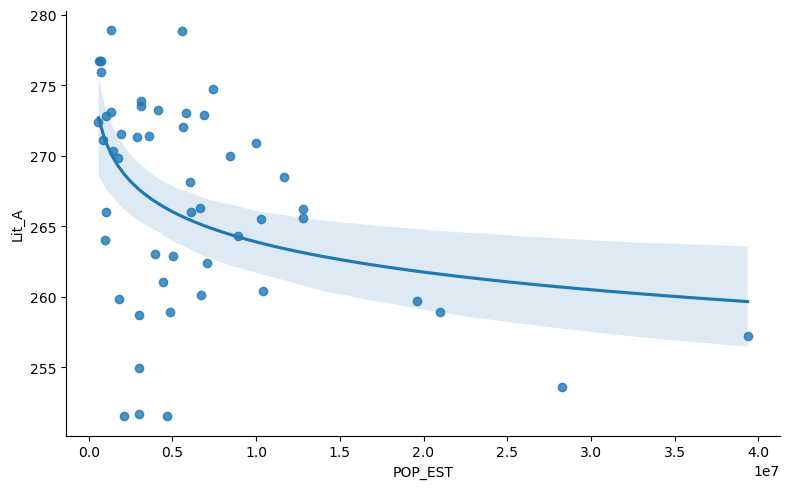

In [3]:
from seaborn import lmplot
lmplot(data=df, x='POP_EST', y='Lit_A', legend=True, logx=True, aspect=1.6)

Yeah the linear model tells us population is negatively correlated with literacy rate.

In [4]:
from sklearn.metrics import r2_score

r2_score(df['POP_EST'], df['Lit_A'])

-0.7795705958398502